In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import folium
import plotly.express as px
import json
import numpy as np
from sklearn.neighbors import BallTree
import folium
from sklearn.metrics.pairwise import haversine_distances

In [20]:
# macOS 기본 한글 폰트 설정 (AppleSDGothicNeo 등)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [5]:
path = '/Users/yniyunj/Desktop/교육공공데이터/데이터/002-전출입생수/'

df_24 = pd.read_csv(path + '2024년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_23 = pd.read_csv(path + '2023년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_22 = pd.read_csv(path + '2022년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_21 = pd.read_csv(path + '2021년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_20 = pd.read_csv(path + '2020년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_19 = pd.read_csv(path + '2019년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_18 = pd.read_csv(path + '2018년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_17 = pd.read_csv(path + '2017년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_16 = pd.read_csv(path + '2016년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_15 = pd.read_csv(path + '2015년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')

In [6]:
df_24.columns

Index(['시도교육청', '교육지원청', '지역', '정보공시 학교코드', '학교명', '학교급코드', '설립구분', '제외여부',
       '제외사유', '1학년 전입학생수', '1학년 전출학생수', '1학년 전체학생수', '2학년 전입학생수', '2학년 전출학생수',
       '2학년 전체학생수', '3학년 전입학생수', '3학년 전출학생수', '3학년 전체학생수', '4학년 전입학생수',
       '4학년 전출학생수', '4학년 전체학생수', '5학년 전입학생수', '5학년 전출학생수', '5학년 전체학생수',
       '6학년 전입학생수', '6학년 전출학생수', '6학년 전체 학생수', '전입학생수(계)', '전출학생수(계)',
       '전체학생수(계)'],
      dtype='object')

# 데이터 전처리

- 2025년도의 각 학교 SCR index 값은??

In [42]:
df_23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6307 entries, 0 to 6306
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   시도교육청       6307 non-null   object 
 1   교육지원청       6307 non-null   object 
 2   지역          6304 non-null   object 
 3   정보공시 학교코드   6307 non-null   object 
 4   학교명         6307 non-null   object 
 5   학교급코드       6307 non-null   int64  
 6   설립구분        6307 non-null   object 
 7   제외여부        6307 non-null   object 
 8   제외사유        4 non-null      object 
 9   1학년 전입학생수   6303 non-null   float64
 10  1학년 전출학생수   6303 non-null   float64
 11  1학년 전체학생수   6303 non-null   float64
 12  2학년 전입학생수   6303 non-null   float64
 13  2학년 전출학생수   6303 non-null   float64
 14  2학년 전체학생수   6303 non-null   float64
 15  3학년 전입학생수   6303 non-null   float64
 16  3학년 전출학생수   6303 non-null   float64
 17  3학년 전체학생수   6303 non-null   float64
 18  4학년 전입학생수   6303 non-null   float64
 19  4학년 전출학생수   6303 non-null  

## 1.1 해당 학교 학생수 감소율 ($S_i$)

- 3년간 연평균 학생수 감소율의 평균
- 단기적으로 학교 규모 축소의 빠르기를 계산   

- $S_i = \frac{1}{3} \sum_{k=1}^3 \frac{총학생수_{k년전} - 총학생수_{k-1년전}}{총학생수_{k년전}}$

In [172]:
# 1. 연도별 필요한 컬럼 추출 (학교코드 + 총학생수만)
df_21_1 = df_21[['정보공시 학교코드', '전체학생수(계)']].rename(columns={'전체학생수(계)': 'student_2021'})
df_22_1 = df_22[['정보공시 학교코드', '전체학생수(계)']].rename(columns={'전체학생수(계)': 'student_2022'})
df_23_1 = df_23[['정보공시 학교코드', '전체학생수(계)']].rename(columns={'전체학생수(계)': 'student_2023'})
df_24_1 = df_24[['정보공시 학교코드', '전체학생수(계)']].rename(columns={'전체학생수(계)': 'student_2024'})

# 2. 병합 (학교코드 기준)
df_merge = df_21_1.merge(df_22_1, on='정보공시 학교코드', how='inner') \
                  .merge(df_23_1, on='정보공시 학교코드', how='inner') \
                  .merge(df_24_1, on='정보공시 학교코드', how='inner')

# 3. S_i 계산
df_merge['S_i(2025)'] = (1/3) * (
    (df_merge['student_2021'] - df_merge['student_2022']) / df_merge['student_2021'] +
    (df_merge['student_2022'] - df_merge['student_2023']) / df_merge['student_2022'] +
    (df_merge['student_2023'] - df_merge['student_2024']) / df_merge['student_2023']
)

# 4. 결과 추출
df_result_1 = df_merge[['정보공시 학교코드', 'S_i(2025)']]

df_result_1 = df_result_1.merge(df_24[['정보공시 학교코드', '학교명', '지역']], on='정보공시 학교코드', how='left')
df_result_1 = df_result_1[['정보공시 학교코드', '지역', '학교명', 'S_i(2025)']]
df_result_1 = df_result_1[df_result_1['지역'].fillna('').str.startswith('충청북도')]

df_result_1 = df_result_1[['지역', '학교명', 'S_i(2025)']].copy()
df_result_1['지역'] = df_result_1['지역'].apply(lambda x: ' '.join(str(x).split()[:2]))
df_result_1.to_csv(path+'/SCR_data/1-S_i(2025).csv', index=False)
df_result_1

,지역,학교명,S_i(2025)
3571,충청북도 청주시,청주교육대학교부설초등학교,0.030908
3572,충청북도 청주시,한국교원대학교부설월곡초등학교,0.057903
3573,충청북도 괴산군,감물초등학교,-0.057043
3574,충청북도 괴산군,괴산명덕초등학교,0.121450
3575,충청북도 증평군,도안초등학교,-0.190013
...,...,...,...
3830,충청북도 충주시,충주중앙탑초등학교,-0.066565
3831,충청북도 청주시,생명초등학교,-inf
3832,충청북도 충주시,충주대소원초등학교,-0.105675
3833,충청북도 충주시,충주남한강초등학교,-0.100296


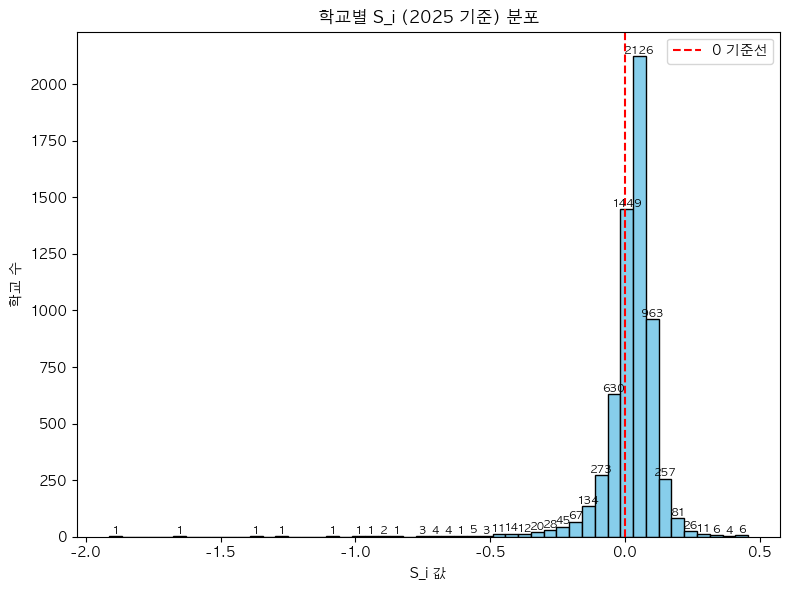

In [50]:
# inf, -inf, NaN 제거
data = df_result_1['S_i(2025)'].replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(8, 6))

# 히스토그램 그리기
counts, bin_edges, patches = plt.hist(
    data, 
    bins=50, 
    color='skyblue', 
    edgecolor='black'
)

# 0 기준선
plt.axvline(0, color='red', linestyle='--', label='0 기준선')

# 각 막대 위에 숫자 표시
for count, x in zip(counts, bin_edges[:-1]):
    if count > 0:
        plt.text(
            x + (bin_edges[1] - bin_edges[0])/2,
            count + 0.5,
            int(count),
            ha='center', va='bottom', fontsize=8
        )

plt.title("학교별 S_i (2025 기준) 분포")
plt.xlabel("S_i 값")
plt.ylabel("학교 수")
plt.legend()
plt.tight_layout()
plt.show()

## 1.2 해당 학교 전출입 증가율 ($T_i$)

- 3년간 연평균 전출 증가율의 평균
- 학생들이 해당 학교를 떠나는 흐름이 가속화되는지 계산   

- $T_i = \frac{1}{3} \sum_{k=1}^3 \frac{전출수_{k년전} - 전입수_{k년전}}{총학생수_{k년전}}$

In [17]:
df_24.columns

Index(['시도교육청', '교육지원청', '지역', '정보공시 학교코드', '학교명', '학교급코드', '설립구분', '제외여부',
       '제외사유', '1학년 전입학생수', '1학년 전출학생수', '1학년 전체학생수', '2학년 전입학생수', '2학년 전출학생수',
       '2학년 전체학생수', '3학년 전입학생수', '3학년 전출학생수', '3학년 전체학생수', '4학년 전입학생수',
       '4학년 전출학생수', '4학년 전체학생수', '5학년 전입학생수', '5학년 전출학생수', '5학년 전체학생수',
       '6학년 전입학생수', '6학년 전출학생수', '6학년 전체 학생수', '전입학생수(계)', '전출학생수(계)',
       '전체학생수(계)'],
      dtype='object')

In [171]:
# 필요한 열만 추출
cols = ['정보공시 학교코드', '지역', '학교명', '전입학생수(계)', '전출학생수(계)', '전체학생수(계)']

# 필요한 연도 데이터 정제
df_22_2 = df_22[cols].copy()
df_23_2 = df_23[cols].copy()
df_24_2 = df_24[cols].copy()

# 연도 정보 추가
df_22_2['year'] = 2022
df_23_2['year'] = 2023
df_24_2['year'] = 2024

# 통합
df_all = pd.concat([df_22_2, df_23_2, df_24_2])

# 계산식: (전출 - 전입) / 전체학생수
df_all['T_i (2025)'] = (df_all['전출학생수(계)'] - df_all['전입학생수(계)']) / df_all['전체학생수(계)']

# 학교별 평균 계산
df_result_2 = df_all.groupby(['정보공시 학교코드', '지역', '학교명'])['T_i (2025)'].mean().reset_index()
df_result_2 = df_result_2[df_result_2['지역'].fillna('').str.startswith('충청북도')]

df_result_2 = df_result_2[['지역', '학교명', 'T_i (2025)']].copy()
df_result_2['지역'] = df_result_2['지역'].apply(lambda x: ' '.join(str(x).split()[:2]))
df_result_2.to_csv(path+'/SCR_data/2-T_i(2025).csv', index=False)
df_result_2

,지역,학교명,T_i (2025)
9,충청북도 청주시,청주교육대학교부설초등학교,0.006705
10,충청북도 청주시,한국교원대학교부설월곡초등학교,0.006550
3645,충청북도 괴산군,감물초등학교,-0.061153
3646,충청북도 괴산군,괴산명덕초등학교,0.040922
3647,충청북도 증평군,도안초등학교,-0.005400
...,...,...,...
3906,충청북도 충주시,충주남한강초등학교,-0.022180
3907,충청북도 청주시,용아초등학교,-0.099035
3908,충청북도 충주시,용원초등학교동락분교장,inf
3909,충청북도 단양군,영춘초등학교별방분교장,0.183333


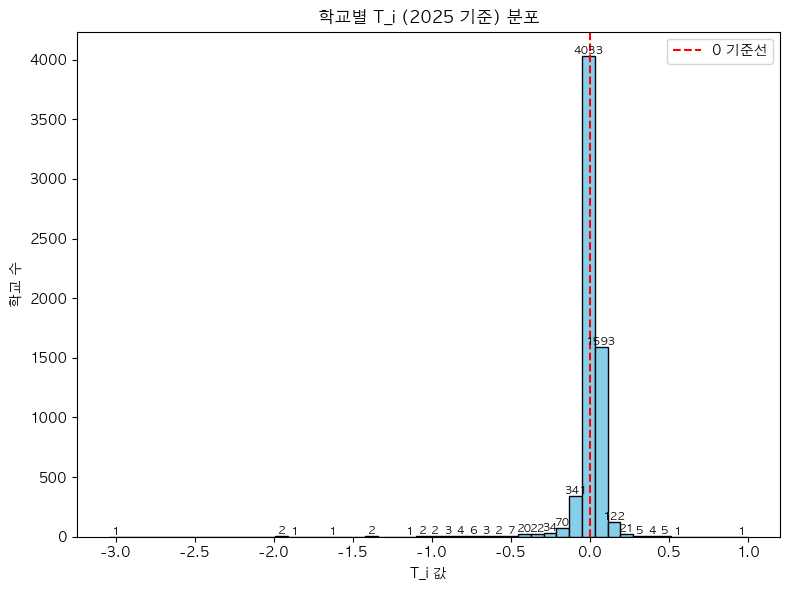

In [53]:
# inf, -inf, NaN 제거
data = df_result_2['T_i (2025)'].replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(8, 6))

# 히스토그램 그리기
counts, bin_edges, patches = plt.hist(
    data, 
    bins=50, 
    color='skyblue', 
    edgecolor='black'
)

# 0 기준선
plt.axvline(0, color='red', linestyle='--', label='0 기준선')

# 각 막대 위에 숫자 표시
for count, x in zip(counts, bin_edges[:-1]):
    if count > 0:
        plt.text(
            x + (bin_edges[1] - bin_edges[0])/2,
            count + 0.5,
            int(count),
            ha='center', va='bottom', fontsize=8
        )

plt.title("학교별 T_i (2025 기준) 분포")
plt.xlabel("T_i 값")
plt.ylabel("학교 수")
plt.legend()
plt.tight_layout()
plt.show()

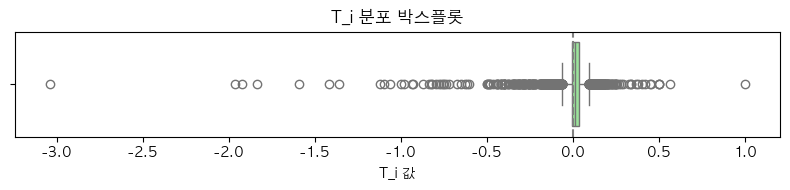

In [55]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=df_result_2['T_i (2025)'], color='lightgreen')
plt.axvline(0, color='gray', linestyle='--')
plt.title("T_i 분포 박스플롯")
plt.xlabel("T_i 값")
plt.tight_layout()
plt.show()

## 1.3 해당 통학구역 신생아수 감소율 ($B_i$)

- 7년간 연평균 신생아수 감소율의 평균 (2020~ 데이터만 존재해서 총 5년(2020-2024) 데이터 사용함)
- 해당 지역의 미래 학령인구 기반이 약화되고 있는 정도   

- $B_i = \frac{1}{7} \sum_{k=1}^7 \frac{신생아수_{k년전} - 신생아수_{k-1년전}}{신생아수_{k년전}}$

In [183]:
df_baby = pd.read_csv(path + '장래_인구변동요인_출생__사망__인구이동_등__20250426125222.csv')
df_baby

,행정구역별(1),2020,2020.1,2020.2,2021,2021.1,2021.2,2022,2022.1,2022.2,2023,2023.1,2023.2,2024,2024.1,2024.2
0,행정구역별(1),인구(명),출생아수(명),조출생률(인구천명당),인구(명),출생아수(명),조출생률(인구천명당),인구(명),출생아수(명),조출생률(인구천명당),인구(명),출생아수(명),조출생률(인구천명당),인구(명),출생아수(명),조출생률(인구천명당)
1,충청북도,1630839,8952,5.5,1632358,8683,5.3,1633687,8375,5.1,1635672,7994,4.9,1637564,8022,4.9
2,청주시,855530,5379,6.3,859652,5319,6.2,861345,5171,6.0,864352,4962,5.7,866741,5000,5.8
3,충주시,216776,1104,5.1,216608,1010,4.7,215972,933,4.3,215787,891,4.1,215637,896,4.2
4,제천시,134741,614,4.6,133885,568,4.2,133755,518,3.9,133210,492,3.7,132610,492,3.7
5,보은군,31666,95,3.0,31369,81,2.6,31179,84,2.7,31016,77,2.5,30926,74,2.4
6,옥천군,48985,168,3.4,48671,145,3.0,48452,127,2.6,48471,118,2.4,48514,115,2.4
7,영동군,47171,195,4.1,46114,152,3.3,45397,132,2.9,44808,121,2.7,44415,119,2.7
8,증평군,37298,205,5.5,36720,225,6.1,37353,251,6.7,37739,243,6.4,37991,245,6.4
9,진천군,89694,596,6.6,92721,590,6.4,93826,575,6.1,94775,548,5.8,95828,550,5.7


In [186]:
# ✅ 필요한 컬럼만 선택
cols = ['행정구역별(1)', '2020.2', '2021.2', '2022.2', '2023.2', '2024.2']
df_selected = df_baby[cols]
df_selected = df_selected.iloc[1:].reset_index(drop=True)

for col in ['2020.2', '2021.2', '2022.2', '2023.2', '2024.2']:
    df_selected[col] = pd.to_numeric(df_selected[col], errors='coerce')

df_selected['B_i(2025)'] = df_selected[['2020.2', '2021.2', '2022.2', '2023.2', '2024.2']].mean(axis=1).round(2)
df_result_3 = df_selected.rename(columns={'행정구역별(1)': '행정구역'})

df_result_3 = df_result_3[['행정구역', 'B_i(2025)']]
df_result_3

,행정구역,B_i(2025)
0,충청북도,5.14
1,청주시,6.00
2,충주시,4.48
3,제천시,4.02
4,보은군,2.64
5,옥천군,2.76
6,영동군,3.14
7,증평군,6.22
8,진천군,6.12
9,괴산군,1.88


In [187]:
df_result_3.to_csv(path + 'SCR_data/3-B_i(2025).csv')

## 1.4 인접학교 밀집도 ($D_i$)

- 폐교해도 대체가 가능한지 보여주는 지표
- 밀집도가 높을수록 전출 가능성↑, 폐교 용이성↑   

- $D_i = 반경 R km 이내의 초등학교 수$

In [165]:
df_24_schools = pd.read_csv(path + '250425-충청북도_학교별_주소_new위도_new경도.csv')
df_24_schools

,Unnamed: 0,학교명,학교도로명 주소,폐교여부,new위도,new경도
0,0,청주교육대학교부설초등학교,충청북도 청주시 서원구 청남로 2067,N,36.617245,127.484741
1,1,한국교원대학교부설월곡초등학교,충청북도 청주시 흥덕구 강내면 가로수로 562,N,36.622385,127.362822
2,2,감물초등학교,충청북도 괴산군 감물면 남양동길 38,N,36.839123,127.871318
3,3,괴산명덕초등학교,충청북도 괴산군 괴산읍 읍내로4길 53,N,36.809356,127.787067
4,4,도안초등학교,충청북도 증평군 도안면 화성로 101,N,36.817063,127.611156
...,...,...,...,...,...,...
292,292,충주남한강초등학교,충청북도 충주시 호암수청2로 55,N,36.955144,127.929240
293,293,용아초등학교,충청북도 청주시 상당구 중고개로142번길 32-15,N,36.618252,127.522719
294,294,용원초등학교동락분교장,충청북도 충주시 신니면 신덕로 301,N,37.003450,127.686138
295,295,영춘초등학교별방분교장,충청북도 단양군 영춘면 별방창원로 449,N,37.096357,128.415812


### 가장 가까운 학교 간 평균거리 계산

- 폐교된 학교를 제외한 학교들
- 가장 가까운 학교 간 평균거리 계산

In [166]:
# 운영 중인 학교만 필터링
df_active = df_24_schools[df_24_schools['폐교여부'] == 'N'].reset_index(drop=True)

# 위경도 radian 변환
coords = np.radians(df_active[['new위도', 'new경도']].values)

# 학교 간 거리 행렬 계산 (km 단위)
EARTH_RADIUS = 6371  # 지구 반지름
dist_matrix = haversine_distances(coords) * EARTH_RADIUS

# 자기 자신과의 거리(0) 제외
np.fill_diagonal(dist_matrix, np.inf)

# 각 학교별 가장 가까운 학교 거리 찾기
min_distances = dist_matrix.min(axis=1)

# 가장 가까운 학교까지 평균 거리
mean_nearest_distance = min_distances.mean()

print(f"운영 중인 학교 간 가장 가까운 학교까지 평균 거리: {mean_nearest_distance:.2f} km")

운영 중인 학교 간 가장 가까운 학교까지 평균 거리: 2.51 km


### 평균거리를 기준으로 근방에 몇 개의 학교가 있는지 계산

In [174]:
# 필요한 데이터 준비
df = df_24_schools.copy()

# 운영중인 학교만 필터링
df_active_4 = df[df['폐교여부'] == 'N'].reset_index(drop=True)

# 위경도 컬럼
coords = np.radians(df_active_4[['new위도', 'new경도']].values)  # Haversine은 radian 단위로 해야 함

# BallTree를 사용해 거리 계산
tree = BallTree(coords, metric='haversine')

# 반경 설정
EARTH_RADIUS = 6371  # km
radius = mean_nearest_distance / EARTH_RADIUS  # 라디안 단위

# 각 학교별 반경 R km 이내 학교 개수 세기
# 자기 자신 포함되니까 -1 해줘야 함
counts = tree.query_radius(coords, r=radius, count_only=True) - 1

# 결과 정리
df_active_4['D_i(2025)'] = counts

# 결과 확인
df_result_4 = df_active_4[['학교도로명 주소', '학교명', 'D_i(2025)']].copy()
df_result_4['학교도로명 주소'] = df_result_4['학교도로명 주소'].apply(lambda x: ' '.join(str(x).split()[:2]))

df_result_4 = df_result_4.rename(columns={'학교도로명 주소': '지역'})
df_result_4.to_csv(path+'/SCR_data/4-D_i(2025).csv', index=False)
df_result_4.sort_values(by='D_i(2025)', ascending=False)

,지역,학교명,D_i(2025)
196,충청북도 청주시,청남초등학교,22
180,충청북도 청주시,석교초등학교,21
157,충청북도 청주시,개신초등학교,20
174,충청북도 청주시,분평초등학교,20
0,충청북도 청주시,청주교육대학교부설초등학교,19
...,...,...,...
80,충청북도 음성군,소이초등학교,0
82,충청북도 음성군,쌍봉초등학교,0
83,충청북도 음성군,오갑초등학교,0
84,충청북도 음성군,오선초등학교,0


### 시각화

/var/folders/2k/10fc4g4d33q5h9qc2fn4wk6m0000gn/T/ipykernel_7692/3728916322.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


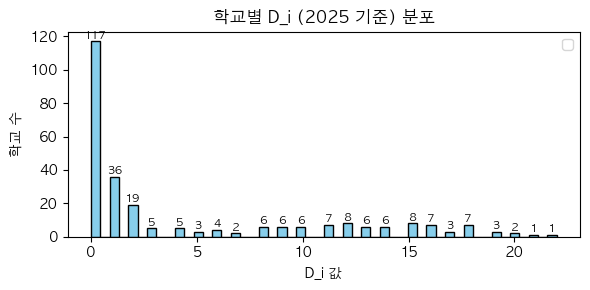

In [104]:
# inf, -inf, NaN 제거
data = df_result_4['D_i(2025)'].replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(6, 3))

# 히스토그램 그리기
counts, bin_edges, patches = plt.hist(
    data, 
    bins=50, 
    color='skyblue', 
    edgecolor='black'
)

# 각 막대 위에 숫자 표시
for count, x in zip(counts, bin_edges[:-1]):
    if count > 0:
        plt.text(
            x + (bin_edges[1] - bin_edges[0])/2,
            count + 0.5,
            int(count),
            ha='center', va='bottom', fontsize=8
        )

plt.title("학교별 D_i (2025 기준) 분포")
plt.xlabel("D_i 값")
plt.ylabel("학교 수")
plt.legend()
plt.tight_layout()
plt.show()

In [105]:
df_result_4.describe()

,D_i(2025)
count,268.000000
mean,4.507463
std,6.211921
min,0.000000
25%,0.000000
50%,1.000000
75%,9.000000
max,22.000000


In [106]:
m = folium.Map(location=[36.8, 127.7], zoom_start=9)

# 모든 학교에 대해 점 + 반경 원 표시
for idx, row in df_24_schools.iterrows():
    lat = row['new위도']
    lon = row['new경도']
    school_name = row['학교명']
    폐교여부 = row['폐교여부']
    
    # 폐교 여부에 따라 색상 결정
    color = 'red' if 폐교여부 == 'Y' else 'green'
    
    # 반경 원 추가
    folium.Circle(
        location=[lat, lon],
        radius = mean_nearest_distance * 1000,  # m
        color=color,  # 원 테두리 색도 폐교여부에 따라
        fill=True,
        fill_color=color,
        fill_opacity=0.1,  # 연하게
        weight=1
    ).add_to(m)

    # 학교 위치 점 추가
    folium.CircleMarker(
        location=[lat, lon],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.9,
        popup=f"{school_name} (폐교여부: {폐교여부})"
    ).add_to(m)

m

## 5. df_result_1, df_result_2, df_result_3, df_result_4,외부조인

In [175]:
# ✅ 첫 번째 병합 (df_result_1 + df_result_2)
df_merge = pd.merge(
    df_result_1,
    df_result_2,
    on=['지역', '학교명'],
    how='outer'
)

# ✅ 두 번째 병합 (df_merge + df_result_4)
df_merge = pd.merge(
    df_merge,
    df_result_4,
    on=['지역', '학교명'],
    how='outer'
)

# ✅ 결과 확인
df_merge

,지역,학교명,S_i(2025),T_i (2025),D_i(2025)
0,충청북도 괴산군,감물초등학교,-0.057043,-0.061153,0.0
1,충청북도 괴산군,괴산명덕초등학교,0.121450,0.040922,2.0
2,충청북도 괴산군,동인초등학교,0.077630,-0.003571,2.0
3,충청북도 괴산군,목도초등학교,-0.054970,-0.067127,0.0
4,충청북도 괴산군,문광초등학교,-0.054032,0.005848,2.0
...,...,...,...,...,...
265,충청북도 충주시,충주용산초등학교,0.068874,-0.005292,8.0
266,충청북도 충주시,충주중앙초등학교,0.014602,0.021007,10.0
267,충청북도 충주시,충주중앙탑초등학교,-0.066565,-0.021174,0.0
268,충청북도 충주시,칠금초등학교,0.107447,0.032160,9.0


In [177]:
# '지역'에서 마지막 단어 추출해서 '행정구역' 컬럼 생성
df_merge['행정구역'] = df_merge['지역'].apply(lambda x: str(x).split()[-1])

0      괴산군
1      괴산군
2      괴산군
3      괴산군
4      괴산군
      ... 
265    충주시
266    충주시
267    충주시
268    충주시
269    충주시
Name: 행정구역, Length: 270, dtype: object

In [195]:
# 병합 (left join)
df_merged_final = pd.merge(
    df_merge,
    df_result_3,
    on='행정구역',
    how='left'
)

df_merged_final = df_merged_final.drop('행정구역',axis=1)
df_merged_final = df_merged_final[['지역','학교명','S_i(2025)','T_i (2025)','B_i(2025)', 'D_i(2025)']]
df_merged_final

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025)
0,충청북도 괴산군,감물초등학교,-0.057043,-0.061153,1.88,0.0
1,충청북도 괴산군,괴산명덕초등학교,0.121450,0.040922,1.88,2.0
2,충청북도 괴산군,동인초등학교,0.077630,-0.003571,1.88,2.0
3,충청북도 괴산군,목도초등학교,-0.054970,-0.067127,1.88,0.0
4,충청북도 괴산군,문광초등학교,-0.054032,0.005848,1.88,2.0
...,...,...,...,...,...,...
265,충청북도 충주시,충주용산초등학교,0.068874,-0.005292,4.48,8.0
266,충청북도 충주시,충주중앙초등학교,0.014602,0.021007,4.48,10.0
267,충청북도 충주시,충주중앙탑초등학교,-0.066565,-0.021174,4.48,0.0
268,충청북도 충주시,칠금초등학교,0.107447,0.032160,4.48,9.0


In [196]:
df_merged_final[df_merged_final.isnull().any(axis=1)]

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025)
26,충청북도 단양군,영춘초등학교별방분교장,NaN,0.183333,2.24,0.0
39,충청북도 보은군,판동초등학교송죽분교장,NaN,0.071429,2.64,0.0
72,충청북도 음성군,능산초등학교,NaN,0.105263,4.28,NaN
133,충청북도 청원군,미원초등학교금관분교장,NaN,NaN,NaN,0.0
162,충청북도 청주시,미원초등학교금관분교장,0.125,0.263889,6.00,NaN
194,충청북도 청주시,오송솔미초등학교,NaN,NaN,6.00,2.0
254,충청북도 충주시,용원초등학교동락분교장,NaN,inf,4.48,0.0


능산초등학교 - df_result_1,df_result_4 에 없음 -> 2023년 3월 1일 폐교   
영춘초등학교별방분교장 - df_result_1 에 없음 -> 2022년 3월 1일 개교   
오송솔미초등학교 - df_result_1, df_result_2 에 없음 -> 2025년 3월 1일 개교   
용원초등학교동락분교장 - df_result_1 에 없음 -> 2022년 3월 1일 개교   
판동초등학교송죽분교장 - df_result_1 에 없음 -> 2022년 3월 1일 개교   

In [197]:
df_merged_final = df_merged_final.drop(index=133).reset_index(drop=True)
df_merged_final[df_merged_final.isnull().any(axis=1)]

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025)
26,충청북도 단양군,영춘초등학교별방분교장,NaN,0.183333,2.24,0.0
39,충청북도 보은군,판동초등학교송죽분교장,NaN,0.071429,2.64,0.0
72,충청북도 음성군,능산초등학교,NaN,0.105263,4.28,NaN
161,충청북도 청주시,미원초등학교금관분교장,0.125,0.263889,6.00,NaN
193,충청북도 청주시,오송솔미초등학교,NaN,NaN,6.00,2.0
253,충청북도 충주시,용원초등학교동락분교장,NaN,inf,4.48,0.0


In [176]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   지역          270 non-null    object 
 1   학교명         270 non-null    object 
 2   S_i(2025)   264 non-null    float64
 3   T_i (2025)  268 non-null    float64
 4   D_i(2025)   268 non-null    float64
dtypes: float64(3), object(2)
memory usage: 10.7+ KB


# 2. 모델링